# Using PyQCS Experiments

Quantum simulations can take quite a while: Applying gates to states takes some time (this time grows exponentially in the number of qbits), and often many samples are required to measure amplitudes with sufficient precision. A typical case is the simulation of Hamiltonian dynamics using trotterization: There are several qbits, deep circuits, and sampling. But we also want to repeat the simulation for several points in time.

The subpackage `pyqcs.experiment` allows for a simple way to parallelize such simulations and run them on clusters using [ray](https://pypi.org/project/ray/).

## Parallelized Hamiltonian Dynamics

To demonstrate the parallelization we will use a simple example of Hamiltonian dynamics: The transverse Ising model in a magnetic field with open boundary conditions. For the Hamiltonian

$$ H = \sum\limits_{i=0}^{n-2} Z_iZ_{i+1} + g\sum\limits_{i=0}^{n-1} X_i $$

we can derive the following Trotterized transfer matrix:

In [1]:
from pyqcs import X, Z, H, R, CX, State, list_to_circuit, sample

def T_interaction(a, b, t):
    theta = -t/2

    return (CX(a, b) | R(a, -theta)
            | X(a) | R(a, theta) | X(a) | CX(a, b))

def T_field(a, t, g):
    theta = g*t/2

    return (H(a) | R(a, -2*theta) | H(a)
            | R(a, theta) | X(a) | R(a, theta) | X(a))

def T_time_slice(qbits, t, g, N):
    interactions_half = list_to_circuit(
                [T_interaction(i, i+1, t/(2*N))
                    for i,_ in enumerate(qbits[:-1])]
            )

    field = list_to_circuit([T_field(i, t/N, g) for i,_ in enumerate(qbits)])

    return (interactions_half | field | interactions_half)


We will run the simulation using $6$ sites, with a magnetic fieldstrength of $g = 3$,
$80$ Trotterization steps, $\Delta t = 0.1$, and a final time of $t_s = 29$. We will measure the amplitude of
the second site and use $2200$ samples:

In [2]:
nqbits = 6
g = 3
N_trot = 80
t_stop = 29
delta_t = 0.1
qbits = list(range(nqbits))

n_sample = 4200
measure = 0b10

In [3]:
measure_coefficient_mask = [False if (i & measure) else True for i in range(2**nqbits)]

Now we build a workflow to compute the probability amplitude at time $t$:

In [4]:
from pyqcs.experiment.workflow import FunctionInstruction, WorkflowSpawner

In [5]:
def simulate_state(t):
    state = State.new_zero_state(nqbits)

    T_dt = T_time_slice(qbits, t, g, N_trot)
    for _ in range(N_trot):
        state = T_dt * state
        
    return state

def sample_result(state):
    result = sample(state, measure, n_sample)
    return result[0] / n_sample

instructions = [
    FunctionInstruction("Simulate Dynamics", simulate_state)
    , FunctionInstruction("Sample the Probability Amplitude", sample_result)
]

wf_spawner = WorkflowSpawner("Transition Probability Simulation", instructions)

A workflow always has a list of instructions: These are callable (in the most simple case just functions), take the result of the previous instruction, and return the input for the next instruction. The first instruction takes the parameters of the workflow; the last instruction returns the final result.

Using `FunctionInstruction` to wrap a function has advantages when logging is turned on.

The `WorkFlowSpawner` is a helper that will create a new `Workflow` using the `spawn` method. This is needed because `ray` requires several actors for parallelization.

Now we can use this workflow to create an `ActorPool` using `ray` and compute the transition amplitudes:

In [7]:
import ray
ray.init() # Connect to your cluster in this step.
#ray.init(address='xxx.xxx.xxx.xxx:6379', _redis_password='5241590000000000')

nworkers = 4 # Use something that matches your CPU count here.

actors = [wf_spawner.spawn() for _ in range(nworkers)]
pool = ray.util.ActorPool(actors)

2020-10-20 15:33:39,405	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


Now we can use this pool to compute the values as a function of time:

In [8]:
import numpy as np

time = np.arange(0, t_stop, delta_t)

results = np.array(list(pool.map(lambda a,v: a.execute.remote(v), time)))

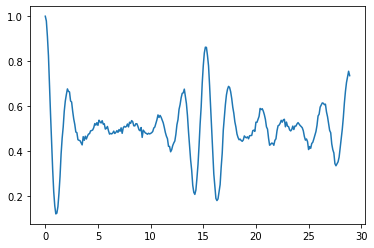

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time, results)

Note that one should estimate the errors on these values but we omit this step.